# ITR 3: The Principal of the Matter
### Author: Ashlynn Wimer

In this ITR, I explore the viability of data reduction techniques for modelling risk of traffic related harm at the census tract level. 

Looking towards the traffic injury literature, clustering approaches appear particularly common, with two strains of clustering approaches seem receiving active usage. The first and most popular approach tends to cluster on traffic crash data directly (Rahimi et al., 2019; Sun et al., 2019; Sivasankaran et al., 2020; Liu & Fan, 2020). These studies run clustering algorithms on crash records directly, usually with the goal of dimension reduction through meaningful discovered crash classifications (Rahimi et al., 2019) or discovery of latent crash types (Sun et al., 2019; Sivasankaran et al., 2020; Liu & Fan, 2020). The second less common but still used approach uses spatial data science methods, such as Moran’s I, kernel density estimation, and the Getis-Ord Gi* index, to identify hotspots, or areas where crashes tend to occur with great frequency (Soltani & Askari, 2017; Gedamu et al., 2024; Khan et al., 2023; Li et al., 2022). Notably, while these studies utilize relatively common spatial data science methods to identify their clusters, research in this strain usually tweaks the methods in interesting ways. Gedamu et al. (2024), for instance, identify spatial autocorrelation on hexagonal grids, while Khan et al. (2023) not only use a network variation of kernel density estimation, but also use space-time cube models to apply temporal labels to hotspots, such as “intensifying”, “persistent”, and “oscillating.”  

Both approaches are broadly useful, but risk leaving useful information on the table. By clustering on only crashes themselves, studies within the first strain can identify types of crashes but are unable to observe potential spatial dependencies within crash types, such as clustering at specific intersections or in specific neighborhoods. Contrarily, studies using hotspot approaches can identify precisely spatial dependencies in crashes but are unable to investigate how these spatial dependencies influence crash characteristics. More concretely, studies using Local Moran’s I can identify that a region is a high-low region, but with current approaches would be unlikely to observe whether the low-region has fewer but more severe crashes, or whether that region has other negative impacts due to crashes. Additionally, both approaches find themselves focusing heavily on traffic crashes proper as the negative outcome of traffic risk, to the detriment of exploring other potential risks (e.g. economic risks).

Towards filling this gap, we investigate the utility of census tract level clustering and dimension reduction techniques on New York City data. We utilize principal component analyses in an attempt to find indices capturing non-physical injuries from traffic crashes, and then use a Bivariate Local Moran's I analysis to create a traffic crash risk hotspot typology. 


## Exploration

We do use pyspark to run three sets of PCA analysis, which we discuss below. Notably, we automate our stopping condition, ceasing to find new components when we enough components to explain 80% of our variance.* This is hoped to give us a useful index or two for future analyses, but we require interpretability from our indices.


_*In theory, we don't need a stopping rule approach for this analysis: we could just generate three components for every four variables and only need to run the analysis once! The reason we do not take that approach and instead recompute the PCA is that this code was designed to "slot in" to a larger analytical pipeline that included normal clustering. Said pipeline was dropped after the PCA itself was interesting._

### PCA

Traffic risk is not just your chance a crash occurs, but also how much harm the crash does. For low socioeconomic status individuals, who have less access to medical care and likely face inequities when receiving care, these harm from the traffic injury itself compounds with other financial harms (e.g. loss of job or going into medical debt) and health harms (e.g. risk of racism experienced during medical visit). It would be nice to have principal components capturing these factors, so we picked five variables to run a PCA on. The variables were:

1. `perBlack`: percentage of people in a given census tract who are black. Picked to proxy for medical racism, and because specifically anti-Black racism is a big focus of our ongoing project.

2. `unempl`: percentage of people unemployed in a given census tract. Picked to proxy risk of job loss. 

3. `percentNoHs`: percentage of census tract without a high school diploma. Picked to proxy health and legal literacy.

4. `perWithoutIns`: percentage of census tract without medical insurance. Picked as not having health insurance could lead to larger insurance costs.

5. `medHouseIncome`: median household income, picked to proxy wealth and ability to pay.

Let's see what our principal components look like:

In [190]:
import pandas as pd

pca_loadings = pd.read_csv('./data/pca_loadings.csv')

pca_loadings

,Unnamed: 0,component,explained_var,perBlack,unempl,percentNoHs,perWithoutIns,medHouseIncome
0,0,0,0.373706,-0.242722,-0.395791,-0.605217,-0.089056,0.640482
1,1,1,0.208947,0.622904,-0.015485,-0.282794,0.726733,0.060316
2,2,2,0.186997,-0.705811,0.043631,0.194917,0.678593,0.038023
3,3,3,0.167747,0.054883,-0.916877,0.258287,0.058299,-0.293622


... we clearly forgot to tell python to _not_ save the row index. Regardless, starting with our explained variances, our first component seems relatively interesting -- it captures nearly 37% of the variance by itself! -- while our second component is less so, only capturing 20% of the variance, or about as much as our initial variables contributed. We quickly hit an elbow, with the last two components not necessarily being worth using. 

Regardless, let's try naming them:

* **PC1**: This component is a little weird to name, but it typically consists of non-black, high school (or above!) educated blocks with relatively higher median income and relatively higher employment rates. Maybe this is a **Wealthy, Edcuated, and Employed** index?

* **PC2**: This component is much more straightforward to name: **Black Uninsured**. It's possible that individuals in this group would have much higher medical friction even compared to those in their same economic class.

* **PC3**: This is a component with less than .2 variance explained -- grumble grumble -- but it appears to be a **Non-Black Uninsured** variable. It's slightly askew from the prior component on the high school education axis, but otherwise these are very similar components..

* **PC4**: This component appears to basically just be **Low-Income Employed**.

Okay, these are viable, but the interpretations aren't the most straightfoward and components 2 and 3 feel very similar, so this wasn't the most _fruitful_ index finding. 

Let's try a try a different approach. Above, we laid out a rationale for at least two different additional routes of harm: financial harm, and a sort of "medical friction" harm. Let's varaible select separately and see if we can get one index for each of those.

For the risk of financial harm, let's pick:

1. `medHouseIncome`: Median household income. Proxy for getting into a house

2. `unemplRate`: Unemployment rate? Proxy for having a job.

3. `medHouseVal`: Median value of a house? Proxy for wealth and income.

4. `perOwnerOcc`: Who owns their houses? Proxy for wealth.

5. `workTravelAv`: how long do people travel to work on average? Proxy for difficulty of getting to one's job.


For the medical friction pca, let's pick:

1. `percentNoHs`: percent of population without a high school diploma. More of this means less health literacy.

2. `percentBach`: percent of population with at least a Bachelors. Also health literacy.

3. `perBlack`: percent of population which is Black. Proxy for medical racism.

4. `perWithoutIns`: percent of population without medical insurance. Less medical insurnace _should_ mean less medical care access.

5. `perOver65`: percent of population over age 65. Goal is to capture agism!

In [191]:
pd.read_csv('./data/finance_pca_loadings.csv')

,Unnamed: 0,component,explained_var,medHouseIncome,unemplRate,medHouseVal,perOwnerOcc,workTravelAv
0,0,0,0.401324,-0.604286,0.374540,-0.541742,-0.192223,0.405123
1,1,1,0.308993,0.189050,-0.348590,-0.285753,0.681006,0.545272
2,2,2,0.144289,-0.289078,-0.856843,-0.142246,-0.402020,-0.020000


Oh, hey, we hit the 40% threshold! That's doing a bit better than the last time. 

Anyway, the first two components capture about 70% of our variance, which is good, so let's name those two.

1. Low median household income, higher unemployment rates, lower median household values, and higher travel time to work is a bit weird. The higher unemployment rate makes this naming dangerous, but I'd argue this is a **Financial Precarity Index** and view the unemployment rate at 0.3 as the "weird" part?

2. This seems to be a **Wealth Index**, based on the higher median household income, incredibly high owner occupancy, and low unemployment.

The Financial Precarity Index might actually be useful as an independent variable for analysis.

In [192]:
pd.read_csv('./data/medical_friction_pca_loadings.csv')

,Unnamed: 0,component,explained_var,percentNoHs,percentBach,perBlack,perWithoutIns,perOver65
0,0,0,0.376632,-0.608280,0.672657,-0.342956,-0.030387,0.242868
1,1,1,0.219926,0.201924,-0.159782,-0.221056,-0.770410,0.539722
2,2,2,0.192245,-0.378637,-0.058694,0.836295,-0.055001,0.388297


Health insurance does not seem to like being grouped with these other variables, but with it here we still get a ~60% variance explained between our top two variables before our third fails the cutoff rule of capturing more than 20% of the variance, so let's stick with the top two.

1. This feels like a **Highly Educated Non-Black** index. It captures groups who tend to be highly educated and non-Black, meaning they're a bit less likely to face some of the race-based disbelief of pain symptoms from doctors in the case of a crash, and likely have higher health literacy. (It's _also_ making me realize that I should look more into what types of medical racism are faced by what groups, since that would help nuance these a bit..)

2. This feels like a **Insured High Need** index. It heavily discourages being insured, and captures a larger amount of aging populations.

3. I don't plan to include this, but just realized that it is very quickly nameable as a **Non-black Uninsured** index. 

Let's run a few basic regressions to explore their relationship to HOLC scores, and maybe make some maps.

In [193]:
def cleanly_read_parquet(save_loc, names=None):
    '''
    The parquets we saved are in a weird format -- retrieve the actual PCA factors.
    '''
    df = pd.read_parquet(save_loc)

    pca_arr = []
    for row in df.values:
        pca_arr.append(row[0]['values'])

    if not names:
        names = [f'pc{i}' for i in range(len(row[0]['values']))]

    df = pd.DataFrame(pca_arr, columns=names)
    
    return df

finance = cleanly_read_parquet('./data/finance_pca_results.parquet', names=['FinPrecInd', 'WealthInd', 'Unnamed: 0'])
med_fric = cleanly_read_parquet('./data/medical_friction_pca_results.parquet', names=['HighEdNB', 'InsHighNeed', 'NBIns'])

med_fric.shape

(2360, 3)

2360 is essentially full data! In a previous run, we only had about 548 results due to forgetting to impute our data first, so this is nice. Let's explore our data with a quick set of pairwise graphs:

In [272]:
import geopandas as gpd

rel_cols = ['unemplRate', 'perOwnerOcc', 'medHouseVal', 'workTravelAv', 'percentNoHs', 'percentBach', 'perBlack', 'perWithoutIns', 'perOver65', 'medHouseIncome']
nyc = gpd.read_file('./data/shapes/nyc_census_imputed.gpkg')

# If we also drop on HRI2020, our sample drops to about 450. Gross!
nyc = nyc[nyc.totalPop != 0].dropna(subset=rel_cols)[['GEOID', 'HRI2010', 'numCrashes', 'geometry']]

In [273]:
nyc['FinPrecInc'] = finance.FinPrecInd
nyc['WealthInd'] = finance.WealthInd
nyc['HighEdNB'] = med_fric.HighEdNB
nyc['InsHighNeed'] = med_fric.InsHighNeed

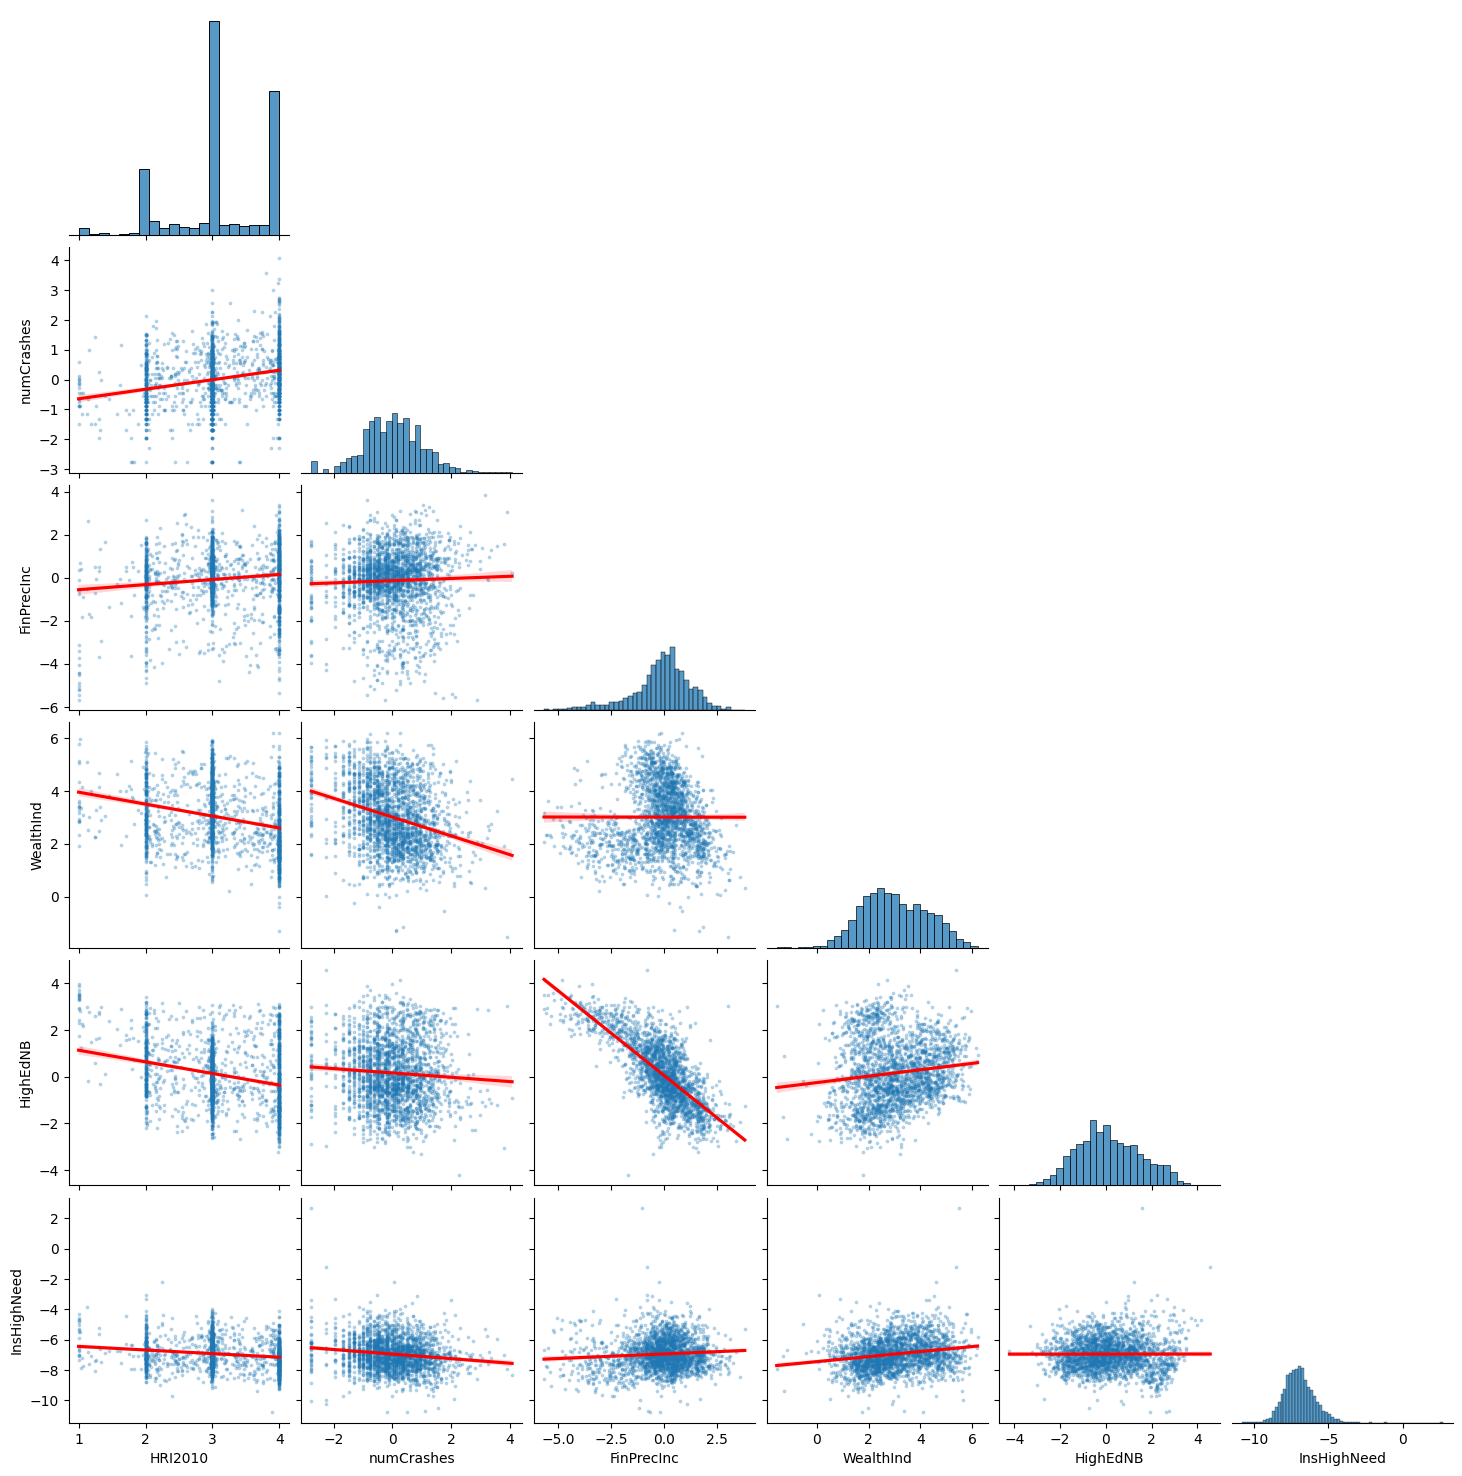

In [274]:
from sklearn.preprocessing import PowerTransformer
import seaborn as sns

pt = PowerTransformer()
nyc['numCrashes'] = pt.fit_transform(nyc[['numCrashes']])

sns.pairplot(nyc.drop('geometry', axis=1), kind='reg', corner=True,
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s':3, 'alpha':.25}})

Okay, this is interesting! Bullet point notes time:

1. `numCrashes` and `HRI2010`* remain somewhat clearly correlated. Notably, we see a wider dispersion in outcomes as `HRI2010` increases, which makes sense -- `HRI2010` _is_ modelling an aspect of these neighborhoods from 100 years ago, so we would expect neighborhoods to have different trajectories in the time since then. We're currently using "off the shelf" historical redlining data from Meier and Mitchell (2023), so we might be able to capture variance a bit more effectively by changing how we model redlined zones (in particular, we would expect largely white D-lined zones to have less disinvestment than largely black D-lined zones) and incorperating a racial shift variable.

2. `FinPrecInd` and `HRI2010` have a noisy slight positive correlation, indicating that areas that were historically redlined have _slightly_ higher financial precarities in modern times. Additionally, there is a _very_ rough positive correlation between `FinPrecInc` and `numCrashes`, indicating that areas where people tend to get into crashes are _also_ areas communities where being involved in a crash is more dangerous financially. Some of the noise may get captured by factoring historical race directly (i.e. what was the racial makeup at the time of the tract being redlined?), instead of just looking at the redlining proxy. Additionally, much of the redlining literature likes to make a split between AB and CD areas. Making such a split on this graph seems to result in a relatively stark difference.

3. `WealthInd` and `HRI2010` are negatively correlated. This is relatively expected -- areas that were historically redlined were denied generational wealth, so we should expect that they would have (e.g.) low owner occupancy rates.  

4. `HighEdNB` and `FinPrecInc` have a _strong_ negative correlation. This result is fun -- it's the strongest result here -- but also slightly trivial, as it amounts to saying "If you are highly educated and not black, you will have higher income and less financial precarity," which... makes sense.

_\*This variable is not discussed deeply in this ITR or elsewhere in my work for this class, but it's a Historical Redlining Index for 2010 census tracts, calculated by Meier and Mitchell (2023). A score of 1 indicates that an area was entirely A rated, while a score of 4 indicates that it was entirely D rated; other neighborhoods have some mixture of ratings._

That's neat! Towards thinking about the "traffic risk" component of our analysis, let's look at a quick maps of `FinPrecInd` and `numCrashes` side by side. Note that `numCrashes` has been power scaled, so it should be interpreted as a relative measurement.

Using the default year of 2021
Using FIPS code '36' for input 'NY'
EPSG:4269


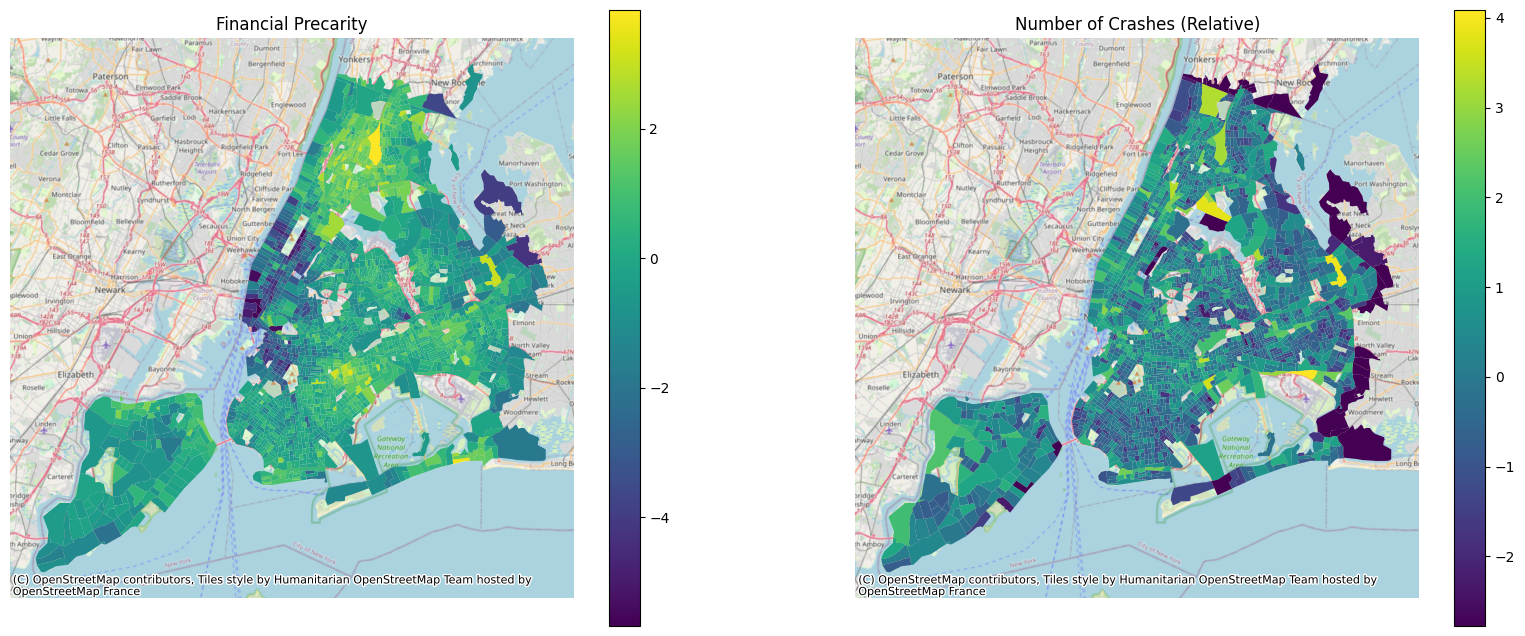

In [281]:
# Okay, cool! 
# Ensure we haven't lost our GDF status -- it just dies sometimes!
import pygris 
import matplotlib.pyplot as plt
import contextily as ctxly

fig, axes = plt.subplots(1, 2)

fig.set_figwidth(20)
fig.set_figheight(8)

# Retrieve cartographic boundaries
pretty_tracts = pygris.tracts(state='NY', cb=True, cache=True)[['GEOID', 'geometry']]

print(pretty_tracts.crs)

nyc_mapping = nyc.drop('geometry', axis=1).merge(pretty_tracts, on='GEOID')
nyc_mapping = gpd.GeoDataFrame(nyc_mapping, geometry=nyc_mapping.geometry)

nyc_mapping.plot(nyc_mapping.FinPrecInc, legend=True, ax=axes[0])
nyc_mapping.plot(nyc_mapping.numCrashes, legend=True, ax=axes[1])

axes[0].set_title('Financial Precarity')
axes[1].set_title('Number of Crashes (Relative)')

for ax in axes:
    ax.set_axis_off()
    ctxly.add_basemap(ax, crs=nyc_mapping.crs.to_string())

Okay, we have a few regions that look like they will be high-high zones (namely a hotspot along the north of the city, as well as slightly north of Gateway National Recreation Area). 

Let's run a Local Moran's Bivariate analysis and see what we get:

In [ ]:
from esda.moran import Moran_Local_BV
from libpysal.weights.distance import Kernel

w_kernel = Kernel.from_dataframe(nyc, function='quadratic')

x = nyc['FinPrecInc'].values
y = nyc['numCrashes'].values

moran_bv = Moran_Local_BV(y, x, w_kernel)

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran BV Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

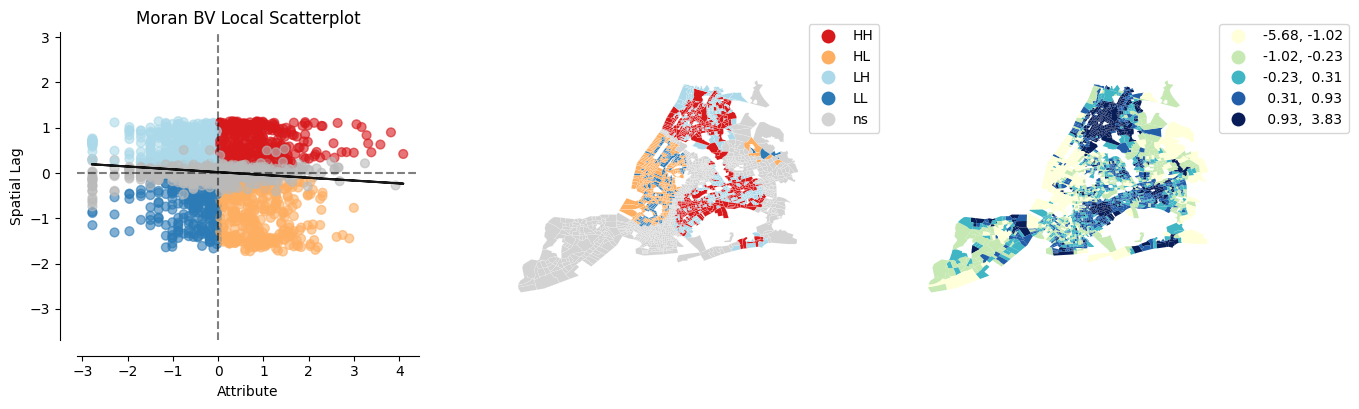

In [ ]:
from splot.esda import plot_local_autocorrelation
# our psuedo-p has been set to 0.0025 so that any results we get are truly interesting results!
plot_local_autocorrelation(moran_bv, nyc, 'FinPrecInc', p=0.0025)

This is an interesting result! First, we found that financial precarity has a _slight_ negative correlation with spatial lag of car crashes, at least using our result. This is the opposite of the relation between financial precarity and the number of crashes directly! It's possible that this is an artifact of the modifeable areal unit problem and our choice of kernel. In particular, high density census tracts are smaller and should thus be expected to have fewer traffic crashes. However, smaller tracts are more densely packed. This means that our kernel -- which essentially takes a weighted average of the values near it, with the contribution of nearby tracts diminishing with $1/r^2$ -- may be counting many small contribution tracts, resulting in the negative correlation. 

Secondly, we have zones! The areas we identified in our informal analysis as potential high-high zones seem to have actually been high-high zones, albeit they are mixed in with a good few low-high zones. Notably, while we have high-high/low-high mixing and low-low/high-low mixing, those two groups stay very separate. This is likely because our financial precarity index has a smoother rate of change than crashes, so that there's quite a bit of variation in crashes even when there is little variation in financial precarity. Thinking towards interpretation, this seems to indicate that multi-neighborhood areas of the city have high (or low) financial precarity, with internal, neighborhood level variation in traffic crash exposure. 

## Reflection

Based on the above analysis, we have evidence that PCA might be useful for extracting relevant risk indices, assuming we can get our variable selection and preprocesing down pat. In our continued project of working towards and modelling broader conceptions of traffic risk, this could be incredibly useful, as having a single variable to regress on or consider the relationship makes any modeling more straightforward to implement and interpret.

In particular, we found a Financial Precarity Index, which believably captures the relative financial burden involvement in a traffic crash could result in. Areas with worse HOLC grades tended to have higher Financial Precarity Indices, providing evidence that historically redlined areas not only have more traffic crashes, but _also_ have higher risk of financial harm from each car crash event.

We additionally explored medical friction components, and found one component capturing highly educated non-black individuals and another component capturing individuals who were insured but older (possibly medicare recipients). Overall, these components are not the most straightforward to interpret, indicating that we either need better variable selection, a different data reduction method, or both.

Lastly, we conducted a Bivariate Local Moran's I analysis, and identified zones of compounding traffic risks. Our results indicated that large, multi-neighborhood sections of New York City tend to have higher (or lower) Financial Precarity, with internal variation on traffic crash risk and exposure.  

Our analysis is limited, with the primary avenue for improvement being the refinement of our Financial Precarity Index. In particular, the current index only captures 40% of the variance of the variables on which it is defined, and is defined on only 5 variables. Our future work should to incorperate additional variables for our index.

## References

Gedamu, W. T., Plank-Wiedenbeck, U., & Wodajo, B. T. (2024). A spatial autocorrelation analysis of road traffic crash by severity using Moran’s I spatial statistics: A comparative study of Addis Ababa and Berlin cities. Accident Analysis & Prevention, 200, 107535. https://doi.org/10.1016/j.aap.2024.107535

Helen C. S. Meier, U. of M. I. for S. R. S. R. C., & Bruce C.  Mitchell, N. C. R. C. (2023). Historic Redlining Indicator for 2000, 2010, and 2020 US Census Tracts [Dataset]. Inter-university Consortium for Political and Social Research (ICPSR). https://doi.org/10.3886/E141121V3

Khan, I. U., Vachal, K., Ebrahimi, S., & Wadhwa, S. S. (2023). Hotspot analysis of single-vehicle lane departure crashes in North Dakota. IATSS Research, 47(1), 25–34. https://doi.org/10.1016/j.iatssr.2022.12.003

Li, X., Yu, S., Huang, X., Dadashova, B., Cui, W., & Zhang, Z. (2022). Do underserved and socially vulnerable communities observe more crashes? A spatial examination of social vulnerability and crash risks in Texas. Accident Analysis & Prevention, 173, 106721. https://doi.org/10.1016/j.aap.2022.106721

Liu, P., & Fan, W. (2020). Exploring injury severity in head-on crashes using latent class clustering analysis and mixed logit model: A case study of North Carolina. Accident Analysis & Prevention, 135, 105388. https://doi.org/10.1016/j.aap.2019.105388

Rahimi, A., Azimi, G., Asgari, H., & Jin, X. (2019). Clustering Approach toward Large Truck Crash Analysis. Transportation Research Record, 2673(8), 73–85. https://doi.org/10.1177/0361198119839347

Sivasankaran, S. K., & Balasubramanian, V. (2020). Exploring the severity of bicycle–vehicle crashes using latent class clustering approach in India. Journal of Safety Research, 72, 127–138. https://doi.org/10.1016/j.jsr.2019.12.012

Soltani, A., & Askari, S. (2017). Exploring spatial autocorrelation of traffic crashes based on severity. Injury, 48(3), 637–647. https://doi.org/10.1016/j.injury.2017.01.032

Sun, M., Sun, X., & Shan, D. (2019). Pedestrian crash analysis with latent class clustering method. Accident Analysis & Prevention, 124, 50–57. https://doi.org/10.1016/j.aap.2018.12.016
